### Codebasics - Bag of N grams tutorial

##### Let's first understand how to generate n-grams using CountVectorizer

In [1]:
from sklearn.feature_extraction.text import CountVectorizer

v = CountVectorizer()
v.fit(["Thor Hathodawala is looking for a job"])
v.vocabulary_

{'thor': 5, 'hathodawala': 1, 'is': 2, 'looking': 4, 'for': 0, 'job': 3}

In [2]:
v = CountVectorizer(ngram_range=(1,2))
v.fit(["Thor Hathodawala is looking for a job"])
v.vocabulary_

{'thor': 9,
 'hathodawala': 2,
 'is': 4,
 'looking': 7,
 'for': 0,
 'job': 6,
 'thor hathodawala': 10,
 'hathodawala is': 3,
 'is looking': 5,
 'looking for': 8,
 'for job': 1}

In [4]:
v = CountVectorizer(ngram_range=(1,3))
v.fit(["Thor Hathodawala is looking for a job"])
v.vocabulary_

{'thor': 12,
 'hathodawala': 2,
 'is': 5,
 'looking': 9,
 'for': 0,
 'job': 8,
 'thor hathodawala': 13,
 'hathodawala is': 3,
 'is looking': 6,
 'looking for': 10,
 'for job': 1,
 'thor hathodawala is': 14,
 'hathodawala is looking': 4,
 'is looking for': 7,
 'looking for job': 11}

We will not take a simple collection of text documents, preprocess them to remove stop words, lemmatize etc and then generate bag of 1 grams and 2 grams from it

In [13]:
corpus = [
    "Thor ate pizza",
    "Loki is tall",
    "Loki is eating pizza"
]

In [14]:
import spacy

# load english language model and create nlp object from it
nlp = spacy.load("en_core_web_sm") 

def preprocess(text):
    # remove stop words and lemmatize the text
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)
    
    return " ".join(filtered_tokens) 

In [15]:
preprocess("Thor ate pizza")

'Thor eat pizza'

In [16]:
preprocess("Loki is eating pizza")

'Loki eat pizza'

In [17]:
corpus_processed = [
    preprocess(text) for text in corpus
]
corpus_processed

['Thor eat pizza', 'Loki tall', 'Loki eat pizza']

In [18]:
v = CountVectorizer(ngram_range=(1,2))
v.fit(corpus_processed)
v.vocabulary_

{'thor': 7,
 'eat': 0,
 'pizza': 5,
 'thor eat': 8,
 'eat pizza': 1,
 'loki': 2,
 'tall': 6,
 'loki tall': 4,
 'loki eat': 3}

Now generate bag of n gram vector for few sample documents

In [21]:
v.transform(["Thor eat pizza"]).toarray()

array([[1, 1, 0, 0, 0, 1, 0, 1, 1]], dtype=int64)

Let's take a document that has out of vocabulary (OOV) term and see how bag of ngram generates vector out of it

In [23]:
v.transform(["Hulk eat pizza"]).toarray()

array([[1, 1, 0, 0, 0, 1, 0, 0, 0]], dtype=int64)

<img src="thor_hulk.jpg" width=800/>

### News Category Classification Problem

Okay now that we know basics of BAG of n grams vectorizer 😎 It is the time to work on a real problem. Here we want to do a news category classification. We will use bag of n-grams and traing a machine learning model that can categorize any news into one of the following categories,

1. BUSINESS
1. SPORTS
1. CRIME
1. SCIENCE

#### Dataset

Dataset Credits: https://www.kaggle.com/code/hengzheng/news-category-classifier-val-acc-0-65

- This data consists of two columns.
        - Text
        - Category
- Text is a news article
- Category can be one of these 4: 'BUSINESS', 'SPORTS', 'CRIME', 'SCIENCE', to keep things simple I trimmed additional categories from the original dataset

In [24]:
import pandas as pd

df = pd.read_json('news_dataset.json')
print(df.shape)

df.head()

(12695, 2)


,text,category
0,Watching Schrödinger's Cat Die University of C...,SCIENCE
1,WATCH: Freaky Vortex Opens Up In Flooded Lake,SCIENCE
2,Entrepreneurs Today Don't Need a Big Budget to...,BUSINESS
3,These Roads Could Recharge Your Electric Car A...,BUSINESS
4,Civilian 'Guard' Fires Gun While 'Protecting' ...,CRIME


In [25]:
df.category.value_counts()

BUSINESS    4254
SPORTS      4167
CRIME       2893
SCIENCE     1381
Name: category, dtype: int64

### **Handle class imbalance**

As you can see above, SCIENCE category has almost 1/3rd data samples compared to BUSINESS and SPORTS categories. I initially trained a model without handling the imbalanced I saw a lower f1-score for SCIENCE category. Hence we need to address this imbalanced. 

There are various ways of handling class imbalance which I have discussed in this video: https://www.youtube.com/watch?v=JnlM4yLFNuo


Out of those techniques, I will use **undersampling** technique here. 

In undersampling, we take a minor class and sample those many samples from other classes, this means we are not utilizing all the data samples for training and in ML world - Not using all the data for training is considered a SIN! 😵 In real life, you are advised to use a technique such as SMOTE so that you can utilize all of your dataset for the training but since this tutorial is more about bag of n-grams then class imbalance itself, I'd go with a simple technique of undersampling. 

In [26]:
min_samples = 1381 # we have these many SCIENCE articles and SCIENCE is our minority class


df_business = df[df.category=="BUSINESS"].sample(min_samples, random_state=2022)
df_sports = df[df.category=="SPORTS"].sample(min_samples, random_state=2022)
df_crime = df[df.category=="CRIME"].sample(min_samples, random_state=2022)
df_science = df[df.category=="SCIENCE"].sample(min_samples, random_state=2022)

In [27]:
df_balanced = pd.concat([df_business,df_sports,df_crime,df_science],axis=0)
df_balanced.category.value_counts()

CRIME       1381
BUSINESS    1381
SPORTS      1381
SCIENCE     1381
Name: category, dtype: int64

**Convert text category to a number**

In [28]:
target = {'BUSINESS': 0, 'SPORTS': 1, 'CRIME': 2, 'SCIENCE': 3}

df_balanced['category_num'] = df_balanced['category'].map({
    'BUSINESS': 0,
    'SPORTS': 1, 
    'CRIME': 2, 
    'SCIENCE': 3
})

In [29]:
df_balanced.head()

,text,category,category_num
11967,GCC Business Leaders Remain Confident in the F...,BUSINESS,0
2912,From the Other Side; an Honest Review from Emp...,BUSINESS,0
3408,"Mike McDerment, CEO of FreshBooks, Talks About...",BUSINESS,0
502,How to Market Your Business While Traveling th...,BUSINESS,0
5279,How to Leverage Intuition in Decision-making I...,BUSINESS,0


**Build a model with original text (no pre processing)**

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_balanced.text, 
    df_balanced.category_num, 
    test_size=0.2, # 20% samples will go to test dataset
    random_state=2022,
    stratify=df_balanced.category_num
)

In [32]:
print(X_train.shape)
X_train.head()

(4419,)


7589     Ovulating Women Prefer Images of Penetration O...
10442    Scientists Discover Spooky Influence On Baby N...
8792     Olympic Race Walker Steps Up To Propose To His...
1733     Beloved Bipedal Bear Named Pedals Believed Kil...
2526     Elizabeth Smart Gave Birth To Baby Girl, Fathe...
Name: text, dtype: object

In [33]:
y_train.value_counts()

3    1105
2    1105
0    1105
1    1104
Name: category_num, dtype: int64

In [34]:
y_test.value_counts()

1    277
3    276
2    276
0    276
Name: category_num, dtype: int64

**Attempt 1 : Use 1-gram which is nothing but a Bag Of Words (BOW) model**

In [36]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

#1. create a pipeline object
clf = Pipeline([
     ('vectorizer_bow', CountVectorizer(ngram_range = (1, 1))),        #using the ngram_range parameter 
     ('Multi NB', MultinomialNB())         
])

#2. fit with X_train and y_train
clf.fit(X_train, y_train)


#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_test)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.87      0.81       276
           1       0.93      0.80      0.86       277
           2       0.83      0.90      0.86       276
           3       0.90      0.80      0.85       276

    accuracy                           0.84      1105
   macro avg       0.85      0.84      0.84      1105
weighted avg       0.85      0.84      0.84      1105



In [58]:
X_test[:5]

3716     african Nation slap Exxon Fine nearly 7 time g...
608               Cringe Worthy Stories hard woman Science
11172    LISTEN Accidental Discovery prove Big Bang Theory
1346     Build Loyalty cost $ 00.00 remember customer h...
1356     Man kill Michigan Police target cop understand...
Name: preprocessed_txt, dtype: object

- BUSINESS: 0
- SPORTS: 1
- CRIME: 2
- SCIENCE: 3

In [56]:
y_pred[:5]

array([0, 3, 3, 0, 2], dtype=int64)

In [57]:
y_test[:5]

3716     0
608      3
11172    3
1346     0
1356     2
Name: category_num, dtype: int64

**Attempt 2 : Use 1-gram and bigrams**

In [37]:
#1. create a pipeline object
clf = Pipeline([
    ('vectorizer_1_2_gram', CountVectorizer(ngram_range = (1, 2))),        #using the ngram_range parameter 
     ('Multi NB', MultinomialNB())         
])

#2. fit with X_train and y_train
clf.fit(X_train, y_train)


#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_test)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.90      0.78       276
           1       0.95      0.74      0.83       277
           2       0.82      0.88      0.85       276
           3       0.92      0.78      0.84       276

    accuracy                           0.82      1105
   macro avg       0.85      0.82      0.83      1105
weighted avg       0.85      0.82      0.83      1105



**Attempt 3 : Use 1-gram to trigrams**

In [38]:
#1. create a pipeline object
clf = Pipeline([
    ('vectorizer_1_3_grams', CountVectorizer(ngram_range = (1, 3))),        #using the ngram_range parameter 
     ('Multi NB', MultinomialNB())         
])

#2. fit with X_train and y_train
clf.fit(X_train, y_train)


#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_test)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.91      0.77       276
           1       0.96      0.73      0.83       277
           2       0.83      0.87      0.85       276
           3       0.93      0.76      0.83       276

    accuracy                           0.82      1105
   macro avg       0.84      0.82      0.82      1105
weighted avg       0.84      0.82      0.82      1105



### Use text pre-processing to remove stop words, punctuations and apply lemmatization

You may wonder, we have not done any text-processing yet to remove stop words, punctuations, apply lemmatization etc. Well we wanted to train the model without any preprocessing first and check the performance. Now we will re-do same thing but with preprocessing of text

In [39]:
df_balanced['preprocessed_txt'] = df_balanced['text'].apply(preprocess) 

In [40]:
df_balanced.head()

,text,category,category_num,preprocessed_txt
11967,GCC Business Leaders Remain Confident in the F...,BUSINESS,0,gcc Business leader remain Confident face Regi...
2912,From the Other Side; an Honest Review from Emp...,BUSINESS,0,Honest Review employee wake morning love impor...
3408,"Mike McDerment, CEO of FreshBooks, Talks About...",BUSINESS,0,Mike McDerment ceo FreshBooks talk give build ...
502,How to Market Your Business While Traveling th...,BUSINESS,0,market business travel World recently amazing ...
5279,How to Leverage Intuition in Decision-making I...,BUSINESS,0,Leverage intuition decision making feel safe r...


**Build a model with pre processed text**

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    df_balanced.preprocessed_txt, 
    df_balanced.category_num, 
    test_size=0.2, # 20% samples will go to test dataset
    random_state=2022,
    stratify=df_balanced.category_num
)

In [42]:
print(X_train.shape)
X_train.head()

(4419,)


7589     ovulate woman prefer Images Penetration image ...
10442     scientist Discover Spooky Influence Baby Choices
8792     Olympic Race Walker step Propose Boyfriend Rio...
1733     Beloved Bipedal Bear name Pedals believe kill ...
2526       Elizabeth Smart give Birth Baby Girl Father say
Name: preprocessed_txt, dtype: object

In [43]:
y_train.value_counts()

3    1105
2    1105
0    1105
1    1104
Name: category_num, dtype: int64

In [44]:
y_test.value_counts()

1    277
3    276
2    276
0    276
Name: category_num, dtype: int64

In [48]:
#1. create a pipeline object
clf = Pipeline([
    ('vectorizer_bow', CountVectorizer(ngram_range = (1, 2))),        #using the ngram_range parameter 
    ('Multi NB', MultinomialNB())
])

#2. fit with X_train and y_train
clf.fit(X_train, y_train)


#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_test)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       276
           1       0.92      0.83      0.87       277
           2       0.83      0.92      0.87       276
           3       0.91      0.81      0.86       276

    accuracy                           0.86      1105
   macro avg       0.87      0.86      0.86      1105
weighted avg       0.87      0.86      0.86      1105



If you compare above classification report for (1,2) gram with the one from unprocessed text, you will find some improvement in the model that uses preprocessed cleaned up text. Hence we can conclude that for this particular problem using preprocessing (removing stop words, lemmatization) is improving the performance of the model

**Plot confusion matrix**

In [49]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[242,   9,  15,  10],
       [ 10, 230,  29,   8],
       [ 15,   1, 255,   5],
       [ 34,  10,   8, 224]], dtype=int64)

Text(69.0, 0.5, 'Truth')

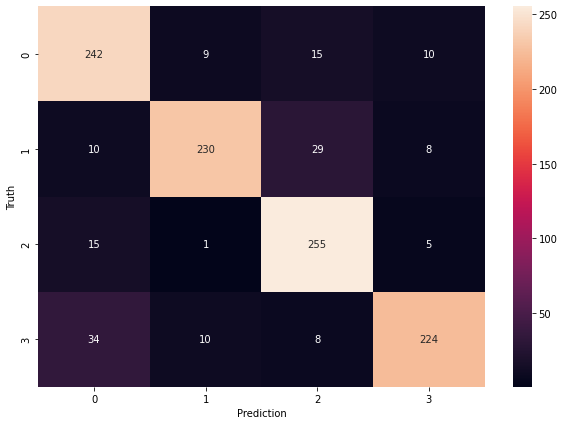

In [50]:
from matplotlib import pyplot as plt
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')